# Clasificacion  y Prediccion de Arritmias Cardiacas usando una Red Neuronal Convolucional

### Edward Fabian Goyeneche


**Datos**

La base de datos de arritmias del MIT-BIH contiene 48 extractos de media hora de registros de ECG ambulatorios de dos canales, obtenidos de 47 sujetos estudiados por el Laboratorio de Arritmias de BIH entre 1975 y 1979. Se eligieron veintitrés registros al azar de un conjunto de 4000 24- registros de ECG ambulatorios de una hora recopilados de una población mixta de pacientes hospitalizados (alrededor del 60%) y ambulatorios (alrededor del 40%) en el Hospital Beth Israel de Boston; los 25 registros restantes se seleccionaron del mismo conjunto para incluir arritmias menos comunes pero clínicamente significativas que no estarían bien representadas en una muestra aleatoria pequeña.
Fuentes: https://physionet.org/content/mitdb/1.0.0/


Arrhythmia Dataset

    Number of Samples: 109446
    Number of Categories: 5
    Sampling Frequency: 125Hz

    Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]


-N : Latidos No-Ectopicos (normales)\
-S : Latidos Ectopicos Supraventriculares\
-V : Latidos Ectopicos Ventriculares\
-F : Latidos de Fusion\
-Q : Latidos desconocidos

**Load Data**

In [1]:
import os

# Ruta base local donde se encuentran tus archivos
base_dir = r'C:\Users\Usuario\Desktop\CNN_Ac'

for dirname, _, filenames in os.walk(base_dir):
    for filename in filenames:
        # Imprime la ruta completa de cada archivo
        print(os.path.join(dirname, filename))



C:\Users\Usuario\Desktop\CNN_Ac\arrhythmia-Model.ipynb
C:\Users\Usuario\Desktop\CNN_Ac\arrhythmia-on-ecg-classification-using-cnn.ipynb
C:\Users\Usuario\Desktop\CNN_Ac\mitbih_test.csv
C:\Users\Usuario\Desktop\CNN_Ac\mitbih_train.csv
C:\Users\Usuario\Desktop\CNN_Ac\ptbdb_abnormal.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import keras 
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')


In [3]:


# Ruta completa a los archivos CSV
train_csv_path = r'C:\Users\Usuario\Desktop\CNN_Ac\mitbih_train.csv'
test_csv_path = r'C:\Users\Usuario\Desktop\CNN_Ac\mitbih_test.csv'

# Carga los archivos CSV en DataFrames
train_df = pd.read_csv(train_csv_path, header=None)
test_df = pd.read_csv(test_csv_path, header=None)



**Balance of dataset**

In [4]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)



187
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64


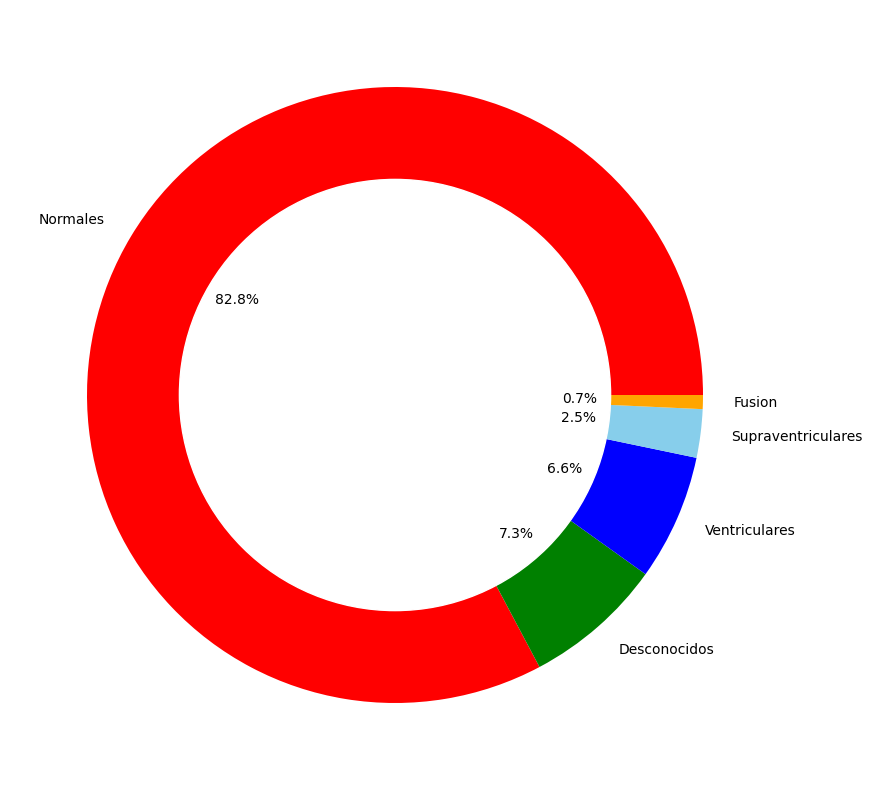

In [5]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['Normales','Desconocidos','Ventriculares','Supraventriculares','Fusion'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Viendo que no hay una paridad o igualdad en los datos, si que se hace  remuestreo para que los datos tengan mas  valor para poder hacer  el algoritmo de clasificacion


In [6]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [7]:
equilibre=train_df[187].value_counts()
print(equilibre)


187
0    20000
1    20000
2    20000
3    20000
4    20000
Name: count, dtype: int64


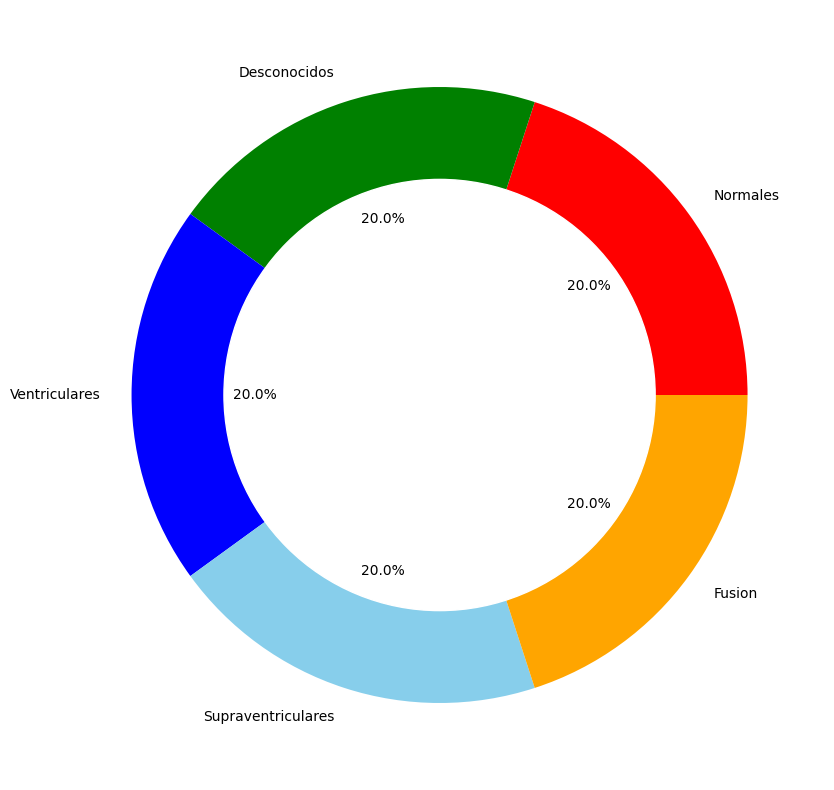

In [8]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['Normales','Desconocidos','Ventriculares','Supraventriculares','Fusion'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

Se  Hace un Resampleo de  todo los datos 

**Classes**

Se ven a Estudiar las Diferentes Clases de las Arritmias 

In [9]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

Se van a  tomar una muestra aleatoria por clases y se almacena en un  marco de datoos pequeños para  tener un ejemplo

In [10]:
c

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
13694,1.000000,0.906890,0.446927,0.000000,0.048417,0.230912,0.264432,0.245810,0.245810,0.245810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
72959,0.991489,0.782979,0.144681,0.000000,0.106383,0.182979,0.140426,0.191489,0.255319,0.246809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
79917,0.000000,0.067717,0.129134,0.237795,0.333858,0.344882,0.341732,0.344882,0.343307,0.349606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80967,0.849091,1.000000,0.860000,0.367273,0.172727,0.110909,0.094545,0.072727,0.063636,0.060000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
86726,0.979070,0.924419,0.874419,0.800000,0.715116,0.616279,0.534884,0.456977,0.418605,0.420930,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


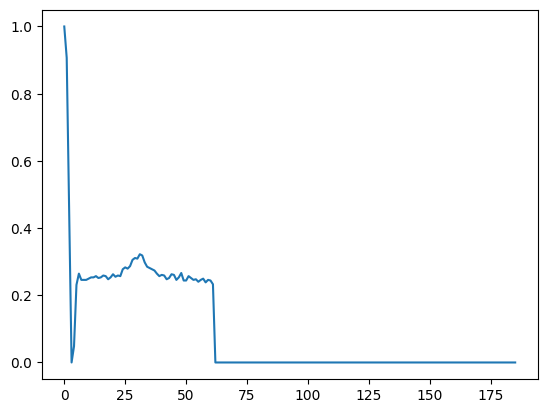

In [11]:
plt.plot(c.iloc[0,:186])

  Ritmo normal , nada que  decir aun de esta clase

In [12]:
def plot_hist(class_number,size,min_,bins):
    img=train_df.loc[train_df[187]==class_number].values
    img=img[:,min_:size]
    img_flatten=img.flatten()

    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.show()

1300000
1300000


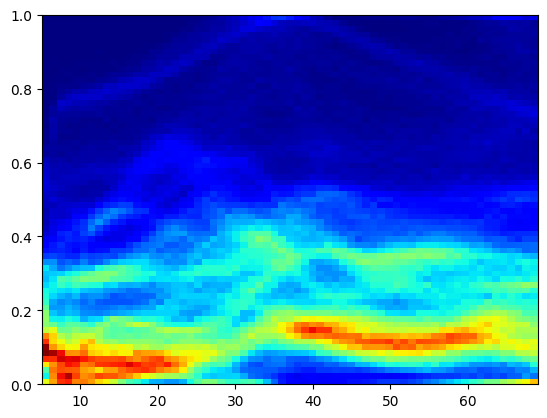

In [13]:
plot_hist(0,70,5,65)

Histograma  bidimencional de todas las clases, se mapean todas la señales y se  tiene una estimacion  de como puede verse la señal

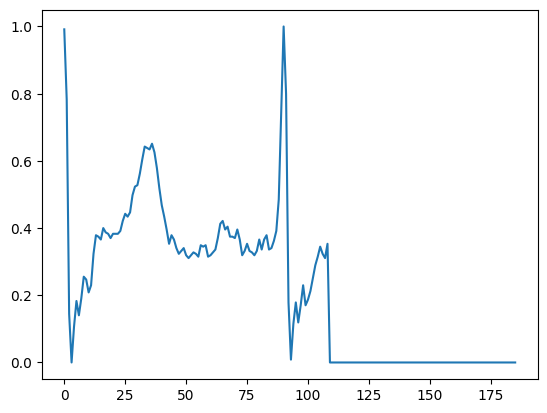

In [14]:
plt.plot(c.iloc[1,:186])

900000
900000


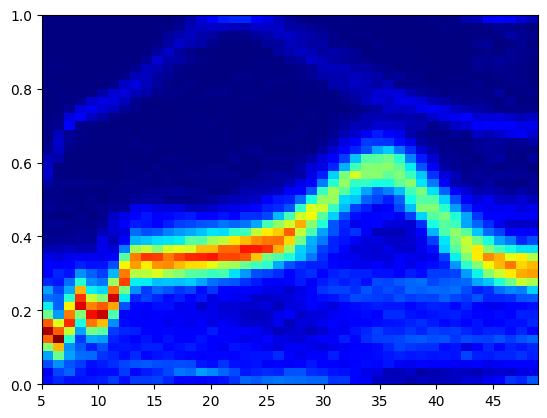

In [15]:
plot_hist(1,50,5,45)

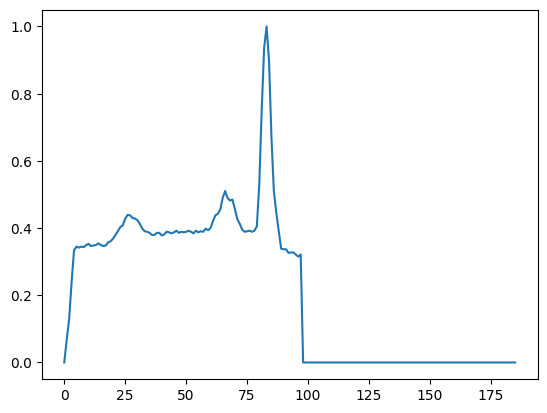

In [16]:
plt.plot(c.iloc[2,:186])

900000
900000


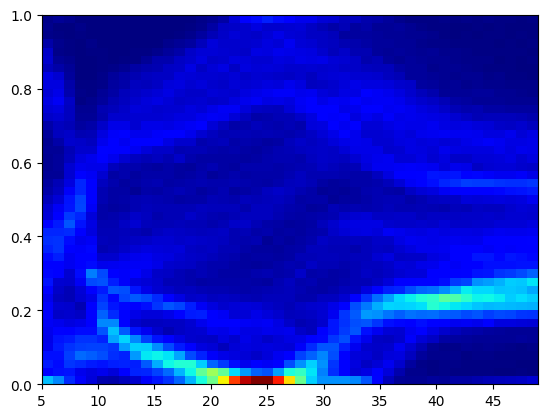

In [17]:
plot_hist(2,50,5,45)

Ejemplo de las Clases

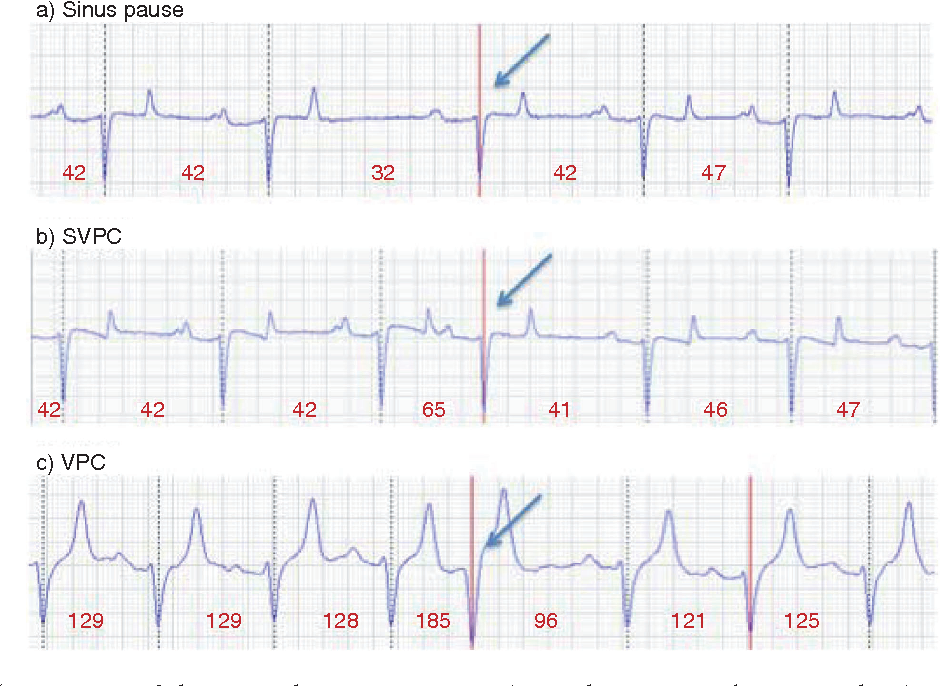



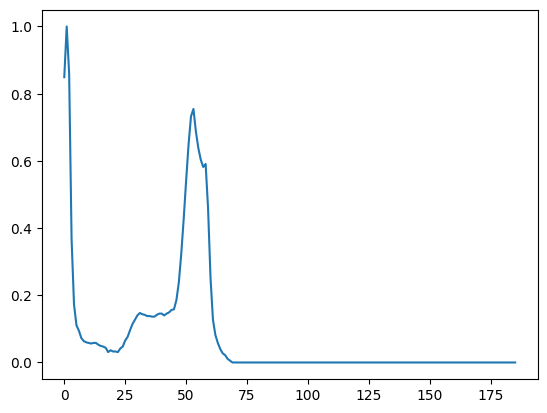

In [18]:
plt.plot(c.iloc[3,:186])

900000
900000


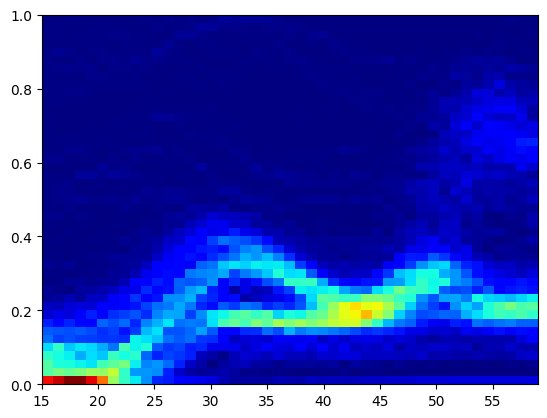

In [19]:
plot_hist(3,60,15,45)

Latidos de Fusion :\
 (Consultar)\
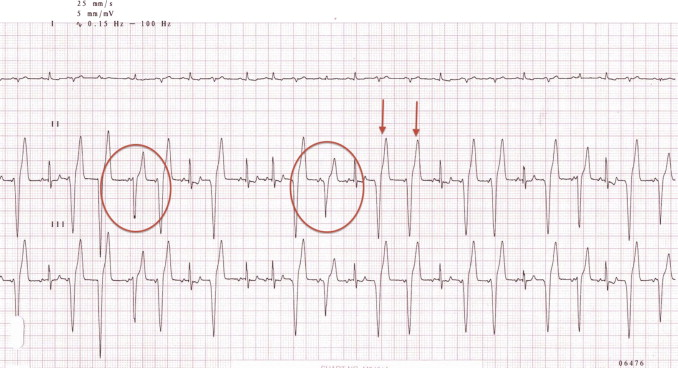

Dejar a interpretacion medica si hay diferencia


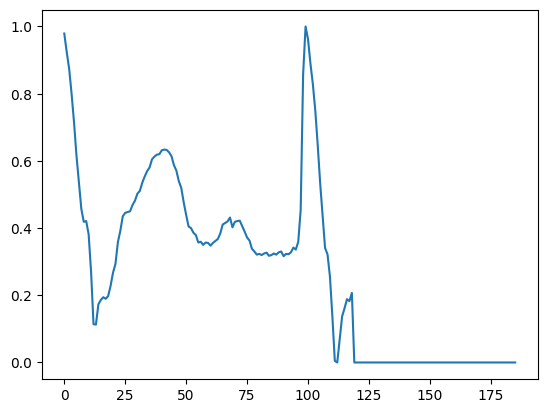

In [20]:
plt.plot(c.iloc[4,:186])

Por suposicion  Se cree que es la SupraVentricular:\

![Supraventricular](https://thumbs.dreamstime.com/z/electrocardiograma-muestra-taquicardia-supraventricular-patr%C3%B3n-svt-fibrilaci%C3%B3n-cardiaca-latido-del-coraz%C3%B3n-ekgvital-signlife-213248130.jpg?w=992)

700000
700000


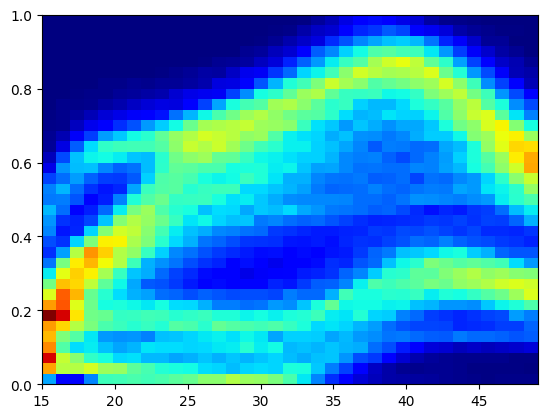

In [21]:
plot_hist(4,50,15,35)

# PREENTRRENAMIENTO DE  La RED


Desde aqui se empienca a  una prueba de entrenamiento   con el conjunto de datos

In [22]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.5,186)
    return (signal+noise)


Se le va agragar ruido a los datos para genrealizar en camino de entreno

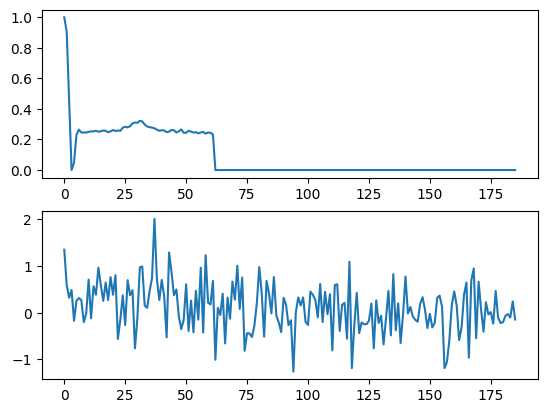

In [23]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()



In [24]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)


In [25]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

**Network**

In [26]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [36]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Exactitud: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Ejemplos de Entreno')
    plt.ylabel('Exactitud')
    plt.title('Model - Exactitud ')
    plt.legend(['Entrenamiento', 'Validacion'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Ejemplos de Entreno')
    plt.ylabel('Perdidas')
    plt.title('Model- Perdidas')
    plt.legend(['Entrenamiento', 'Validacion'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

In [32]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)
    

Epoch 1/40
3125/3125 [==============================] - 57s 18ms/step - loss: 0.9101 - accuracy: 0.6505 - val_loss: 1.0933 - val_accuracy: 0.5990
Epoch 2/40
3125/3125 [==============================] - 57s 18ms/step - loss: 0.7992 - accuracy: 0.6975 - val_loss: 1.0412 - val_accuracy: 0.6551
Epoch 3/40
3125/3125 [==============================] - 56s 18ms/step - loss: 0.7653 - accuracy: 0.7095 - val_loss: 1.2909 - val_accuracy: 0.3985
Epoch 4/40
3125/3125 [==============================] - 58s 19ms/step - loss: 0.7393 - accuracy: 0.7194 - val_loss: 1.1862 - val_accuracy: 0.4799
Epoch 5/40
3125/3125 [==============================] - 59s 19ms/step - loss: 0.7146 - accuracy: 0.7291 - val_loss: 0.6654 - val_accuracy: 0.7852
Epoch 6/40
3125/3125 [==============================] - 57s 18ms/step - loss: 0.6908 - accuracy: 0.7372 - val_loss: 0.6734 - val_accuracy: 0.7606
Epoch 7/40
3125/3125 [==============================] - 58s 19ms/step - loss: 0.6657 - accuracy: 0.7463 - val_loss: 0.7338 -

Exactitud: 78.52%


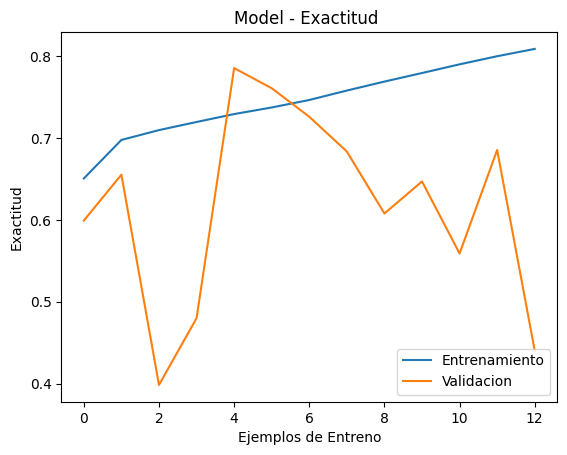

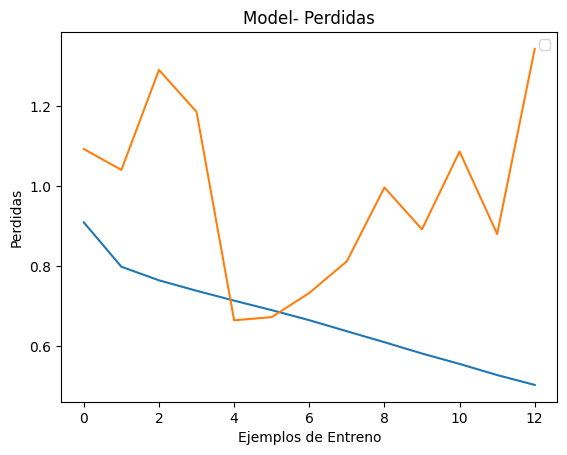

685/685 [==============================] - 3s 4ms/step


In [37]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)


Matriz de Confusion Normalizada


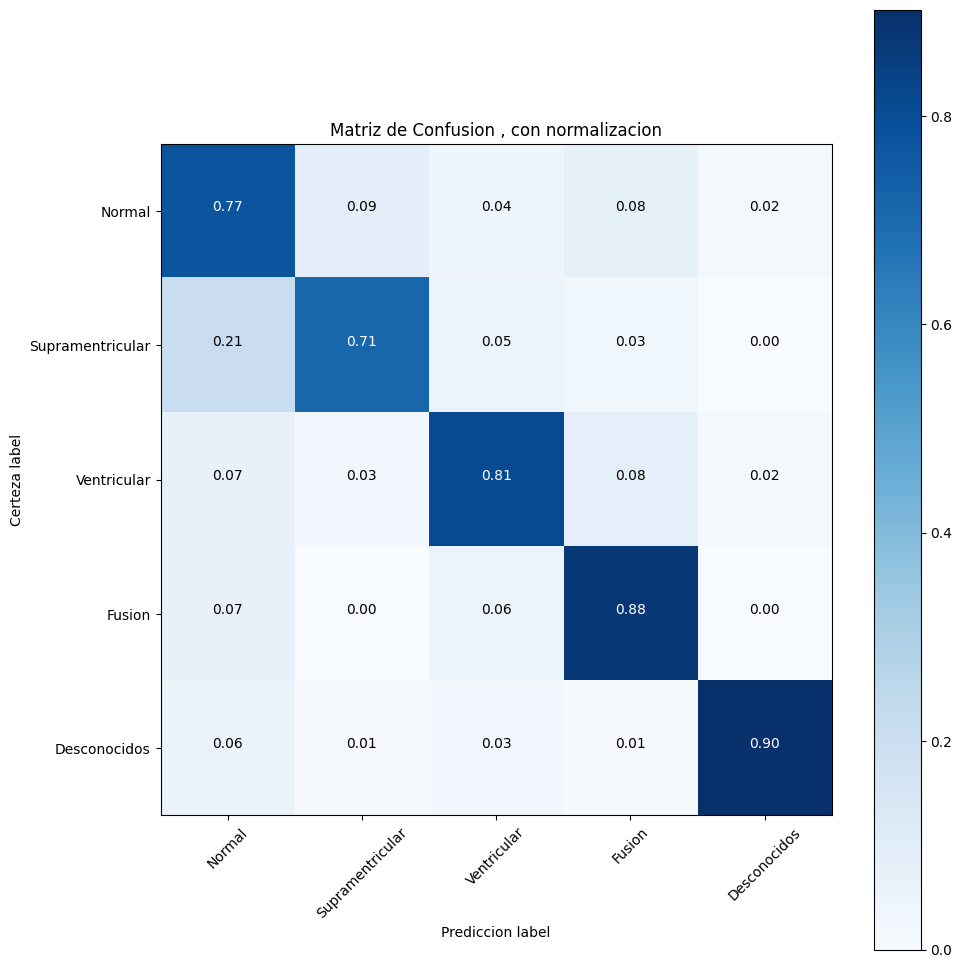

In [38]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confusion',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de Confusion Normalizada")
    else:
        print('Matriz de confusión, sin normalización.')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Certeza label')
    plt.xlabel('Prediccion label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Supramentricular', 'Ventricular', 'Fusion', 'Desconocidos'],normalize=True,
                      title='Matriz de Confusion , con normalizacion')
plt.show()



Las Clases Supraventricular y fusion, tal vez  haya en error en su interpretacion  pero son mas debiles,  o tal vez  es debido a  no tener  tantos valores al conjunto iniicial
